In [1]:
import json
from collections import Counter
import pickle
import torch_geometric
import torch
import torch.nn.functional as F
from torch import nn
from torch_geometric.nn import GATConv, global_mean_pool
import matplotlib.pyplot as plt
import seaborn as sns
import math
from torch_geometric.data import Data, DataLoader
import random
import time
from earlystopping import EarlyStopping
import numpy as np
from torch.nn.utils.rnn import pad_sequence
import os, psutil


In [2]:
NUM_FILES_TRAIN = 100

In [3]:
infile = open('common_Terminals','rb')
common_terminals = pickle.load(infile)
infile.close()

In [4]:
infile = open('map_terminals_val','rb')
map_terminals_val = pickle.load(infile)
infile.close()

In [5]:
infile = open('map_terminals_type','rb')
map_type = pickle.load(infile)
infile.close()

In [6]:
def non_terminal(node):
    if('children' in node):
        return True
    return False

curr_idx = 0
map_idx_val = {}


def dfs(program, idx, flattened_tree, edge_list1, edge_list2, map_right_sibling, map_non_terminal_child):
    global curr_idx
    global map_idx_val
    node = program[idx]
    map_idx_val[idx] = curr_idx
    curr_idx += 1
    if(non_terminal(node)):
        x = non_terminals_mapping[(map_type[node['type']], map_right_sibling[idx], map_non_terminal_child[idx])]
        flattened_tree.append([x, map_terminals_val['none']])
        for i in node['children']:
            dfs(program, i, flattened_tree, edge_list1, edge_list2, map_right_sibling, map_non_terminal_child)
        for i in node['children']:
            edge_list1.append(map_idx_val[idx])
            edge_list2.append(map_idx_val[i])
            edge_list1.append(map_idx_val[i]) #Bi-directional edges
            edge_list2.append(map_idx_val[idx])
            
    else:
        val = ""
        if(node['value'] not in map_terminals_val):
            val = map_terminals_val['UNK']
        else:
            val = map_terminals_val[node['value']]
        x = non_terminals_mapping[(map_type[node['type']], 0, 0)]
        flattened_tree.append([x, val])
            

def construct_Seq(program):
    global curr_idx
    global map_idx_val
    map_right_sibling = {}
    map_non_terminal_child = {}
    tokens = []
    edge_list1 = []
    edge_list2 = []
    flattened_tree = []
    map_right_sibling[0] = False
    for node in program:
        if(non_terminal(node)):
            for i in range(len(node['children'])):
                if(i + 1 == len(node['children'])):
                    map_right_sibling[node['children'][i]] = False
                else:
                    map_right_sibling[node['children'][i]] = True
            non_terminal_child = False
            for i in node['children']:
                if('children' in program[i]):
                    non_terminal_child = True
                    break
            map_non_terminal_child[node['id']] = non_terminal_child
    curr_idx = 0
    map_idx_val = {}
    dfs(program, 0, flattened_tree, edge_list1, edge_list2, map_right_sibling, map_non_terminal_child)
    return flattened_tree, edge_list1, edge_list2

In [24]:
non_terminals_mapping = {}
c = 0
for i in range(46):
    for j in range(2):
        for k in range(2):
            non_terminals_mapping[(i, j, k)] = c
            c += 1
            
inverse_mapping = {}
for i in non_terminals_mapping:
    inverse_mapping[non_terminals_mapping[i]] = i[0]

In [8]:
data = []
train_data = []
count = 0
with open('programs_training.json', encoding='latin1') as f:
    for line in f:
        count += 1
        t = json.loads(line)
        t.pop()
        last_elem = t[-1]['id']
        d = {'id' : last_elem + 1, 'type': "EOF", 'value' : "EOF"}
        t.append(d)
        for j in t:
            if("children" not in j and "value" not in j):
                j['value'] = j['type']
        tree, edge1, edge2 = construct_Seq(t)
        edge_list = torch.tensor([edge1, edge2], dtype = torch.long)
        #print(tree, edge_list)
        tree = torch.tensor(tree, dtype = torch.long)
        train_data.append(tree)
        #data.append(t)
        if(count % 1000 == 0):
            print(count/1000)

1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
18.0
19.0
20.0
21.0
22.0
23.0
24.0
25.0
26.0
27.0
28.0
29.0
30.0
31.0
32.0
33.0
34.0
35.0
36.0
37.0
38.0
39.0
40.0
41.0
42.0
43.0
44.0
45.0
46.0
47.0
48.0
49.0
50.0
51.0
52.0
53.0
54.0
55.0
56.0
57.0
58.0
59.0
60.0
61.0
62.0
63.0
64.0
65.0
66.0
67.0
68.0
69.0
70.0
71.0
72.0
73.0
74.0
75.0
76.0
77.0
78.0
79.0
80.0
81.0
82.0
83.0
84.0
85.0
86.0
87.0
88.0
89.0
90.0
91.0
92.0
93.0
94.0
95.0
96.0
97.0
98.0
99.0
100.0


In [9]:
print(len(train_data))

100000


In [11]:
def constructTensorfromProgram(data):
    res = torch.split(data, 50)
    res = list(res)
    if(res[-1].shape[0] != 50):
        x = non_terminals_mapping[(map_type['EOF'], 0, 0)]
        dummy_tensor = torch.tensor([x, map_terminals_val['none']])
        dummy_tensor = dummy_tensor.repeat((50 - res[-1].shape[0], 1))
        dummy_tensor = torch.cat([res[-1], dummy_tensor])
        res = res[:-1]
        res.append(dummy_tensor)
    res = torch.stack(res, dim = 0)
    ans = res[:, 49, :]
    res = res[:, :-1, :]
    ans[:, 0].apply_(lambda x : inverse_mapping[x])
    return res, ans

In [32]:
def RAM():
    process = psutil.Process(os.getpid())
    print(process.memory_info().rss/1024/1024/1024)

In [17]:
SEQ_LEN = 49
NUM_CLASSES_VALUE = len(map_terminals_val) + 1
NUM_CLASSES_TYPE = len(non_terminals_mapping) + 1
WORD_EMBEDDING_DIM1 = 128
WORD_EMBEDDING_DIM2 = 64
HIDDEN_SIZE = 512

class Graph2CodeNet(torch.nn.Module):
    def __init__(self):
        super(Graph2CodeNet, self).__init__()
        self.embeddingLayervalue = nn.Embedding(NUM_CLASSES_VALUE, WORD_EMBEDDING_DIM1)
        self.embeddingLayertype = nn.Embedding(NUM_CLASSES_TYPE, WORD_EMBEDDING_DIM2)
        self.GRU = nn.GRU(input_size =WORD_EMBEDDING_DIM1 + WORD_EMBEDDING_DIM2, hidden_size = HIDDEN_SIZE, 
                          batch_first = True, num_layers = 2, bidirectional = True)
        self.linearTerminal = nn.Linear(in_features = HIDDEN_SIZE * 4, out_features = 10002)
        self.linearNon_Terminal = nn.Linear(in_features = HIDDEN_SIZE * 4, out_features = 46)
        
        

    def forward(self, x, h_0):
        h_0.to(device)
        x.to(device)
        typeEmbedded = self.embeddingLayertype(x[:,:,0])
        valEmbedded = self.embeddingLayervalue(x[:,:,1])
        x = torch.cat((typeEmbedded, valEmbedded), 2)
        _, h_n = self.GRU(x, h_0)
        y = h_n.view(h_n.shape[1], -1)
        out2 = self.linearNon_Terminal(y)
        #print(out.shape)
        return out2, h_n
    
    
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [18]:
model = Graph2CodeNet()

In [20]:
device = torch.device('cuda:0')
model = model.to(device)

In [21]:
random.shuffle(train_data)

Train time is: 0.011936787764231365 -> 0.0%
Train time is: 4.667750199635823 -> 0.025%
Train time is: 9.492753513654073 -> 0.05%
Train time is: 14.208226148287455 -> 0.075%
Train time is: 18.712927687168122 -> 0.1%
Train time is: 23.145308077335358 -> 0.125%
Train time is: 28.49252483447393 -> 0.15%
Train time is: 33.033630565802255 -> 0.175%
Train time is: 37.886666576067604 -> 0.2%
Train time is: 42.652442053953806 -> 0.225%
Train time is: 47.380858874320985 -> 0.25%
Train time is: 52.212037257353465 -> 0.275%
Train time is: 56.802160092194875 -> 0.3%
Train time is: 61.44942443370819 -> 0.325%
Train time is: 66.00965468883514 -> 0.35%
Train time is: 70.70394931634267 -> 0.375%
Train time is: 75.04670576651891 -> 0.4%
Train time is: 79.89841272036234 -> 0.425%
Train time is: 84.50318694114685 -> 0.45%
Train time is: 89.12033751010895 -> 0.475%
Train time is: 94.147063990434 -> 0.5%
Train time is: 98.83363924423854 -> 0.525%
Train time is: 103.49698944886525 -> 0.55%
Train time is: 107

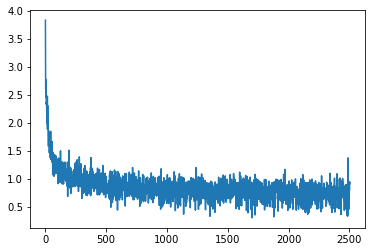

In [25]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())
BATCH_SIZE = 256

train_losses = 0
avg_train_losses = []

start = time.time()
count = 0
idx = 0
for i in train_data:
    h_0 = torch.zeros(4, 1, 512)
    h_0 = h_0.to(device)
    res, ans = constructTensorfromProgram(i)
    for j in range(res.shape[0]):
        x = res[j, :,:].view(1, 49, -1)
        x = x.to(device)
        out_N, h_0 = model(x, h_0)
        count += 1       
        ans1 = ans[j, 0:1]
        ans1 = ans1.to(device)
        loss = criterion(out_N, ans1) #ANS IS TO BE PROCESSED
        loss.backward()
        nn.utils.clip_grad_value_(model.parameters(), clip_value = 5.0)
        train_losses += loss.item()
        if(count % BATCH_SIZE == 0):
            avg_train_losses.append(train_losses / BATCH_SIZE)
            train_losses = 0
            optimizer.step()
            optimizer.zero_grad()
        h_0.detach_()
        if(j > 100):
            break
    if(idx % 1000 == 0):
        print(f"Train time is: {(time.time() - start)/60} -> {idx / 40000}%")
    if(idx >= 40000):
        break
    idx += 1
        
plt.plot(avg_train_losses)
end = time.time()
print("Time taken:", (end - start)/60)

In [26]:
eval_data = train_data[80000:]

In [30]:
with torch.no_grad():
    total = 0
    correct = 0
    for i in eval_data:
        h_0 = torch.zeros(4, 1, 512)
        h_0 = h_0.to(device)
        res, ans = constructTensorfromProgram(i)
        for j in range(res.shape[0]):
            x = res[j, :,:].view(1, 49, -1)
            x = x.to(device)
            out_N, h_0 = model(x, h_0)
            total += 1       
            #print(ans.shape)
            ans1 = ans[j, 0:1]
            ans1 = ans1.to(device)
            out_N = torch.argmax(out_N, dim = 1)
            #print(ans1.shape)
            #print(torch.argmax(out_N, dim = 1).shape)
            correct += sum(out_N == ans1).item()
            if(total >= 10000):
                break
        if(total >= 10000):
            break
print(f"Validation set prediction acccuracy is: {100*correct/total}%")

Validation set prediction acccuracy is: 72.52%


In [31]:
print(model)

Graph2CodeNet(
  (embeddingLayervalue): Embedding(10002, 128)
  (embeddingLayertype): Embedding(185, 64)
  (GRU): GRU(192, 512, num_layers=2, batch_first=True, bidirectional=True)
  (linearTerminal): Linear(in_features=2048, out_features=10002, bias=True)
  (linearNon_Terminal): Linear(in_features=2048, out_features=46, bias=True)
)
